In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.agents.stablebaselines3.models import hyperparameterized_model_name, MODELS


from pprint import pprint

import sys
import itertools


/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [8]:
!pip install -e ~/Workspace/AI4Finance/FinRL


Obtaining file:///Users/tonyren/Workspace/AI4Finance/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-a_zbqm4p/elegantrl_3c877faae8844806969456f2fdb7c1a5
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-a_zbqm4p/elegantrl_3c877faae8844806969456f2fdb7c1a5
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl size=9103 sha256=ebb9a360ce7d0d9eb

In [1]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [57]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2022-11-10'
TEST_START_DATE = '2022-11-11'
TEST_END_DATE = '2024-11-11'

INDICATORS = ['close_-1_s','close_-2_s','close_-3_s','close_-4_s','close_-5_s', 'close_0_s']
CUSTOM_TICKER = [
    "INTC"
]
def dummy_stock(n, type='flat'):
    if type == 'flat':
        return [10]*n
    if type == 'triangle':
       return ((list(np.arange(100,2000,100)) + list(np.arange(2000,100,-100)))*n)[0:n]
    if type == 'up':
       return list(np.arange(10,20000,(20000-10)/n))[0:n]
    if type == 'down':
       return list(np.arange(20000,10,(10-20000)/n))[0:n]

if True:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    df['close'] = dummy_stock(df.shape[0], type='triangle')
    df['open'] = dummy_stock(df.shape[0], type='triangle')
    df['low'] = dummy_stock(df.shape[0], type='triangle')
    df['high'] = dummy_stock(df.shape[0], type='triangle')
    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed['close_-1_s'] = 100*(processed['close']-processed['close_-1_s'])/processed['close_-1_s']
    processed['close_-2_s'] = 100*(processed['close']-processed['close_-2_s'])/processed['close_-2_s']
    processed['close_-3_s'] = 100*(processed['close']-processed['close_-3_s'])/processed['close_-3_s']
    processed['close_-4_s'] = 100*(processed['close']-processed['close_-4_s'])/processed['close_-4_s']
    processed['close_-5_s'] = 100*(processed['close']-processed['close_-5_s'])/processed['close_-5_s']
    processed.to_csv("datasets/processed_sanity.csv", index=False)



[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3739, 8)
Successfully added technical indicators
Successfully added turbulence index


In [58]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 9


In [59]:
train = data_split(
                processed,
                start='2010-01-01',
                end='2021-10-01',
            )

validation = data_split(
                processed,
                start='2021-10-01',
                end='2023-03-01'
            )

In [101]:
num_stock = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

env = VecNormalize(DummyVecEnv(
            [
                lambda: StockTradingEnv(
                    df=train,
                    stock_dim=num_stock,
                    hmax=1000,
                    initial_amount=1000000,
                    num_stock_shares=[0] * num_stock,
                    buy_cost_pct=[0.001] * num_stock,
                    sell_cost_pct=[0.001] * num_stock,
                    reward_scaling=1,
                    state_space=state_space,
                    action_space=num_stock,
                    tech_indicator_list=INDICATORS,
                    turbulence_threshold=100000,
                    initial=True,
                    previous_state=[],
                    model_name='test',
                    mode="trade",
                    iteration=0,
                    print_verbosity=1,
                    model_file_suffix='robustness'
                )
            ]
        ), norm_obs=True, norm_reward=True)

In [102]:
from stable_baselines3 import PPO, A2C, DDPG

model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=10000)

day: 2956, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 381769594.20
total_reward: 380769594.20
total_cost: 2005405.80
total_trades: 2373
Sharpe: 1.130
day: 2956, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 755202723.10
total_reward: 754202723.10
total_cost: 1972776.90
total_trades: 1970
Sharpe: 2.912
day: 2956, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 766777380.80
total_reward: 765777380.80
total_cost: 1902019.20
total_trades: 1865
Sharpe: 3.089


In [103]:
val_env = VecNormalize(DummyVecEnv(
            [
                lambda: StockTradingEnv(
                    df=validation,
                    stock_dim=num_stock,
                    hmax=1000,
                    initial_amount=1000000,
                    num_stock_shares=[0] * num_stock,
                    buy_cost_pct=[0.001] * num_stock,
                    sell_cost_pct=[0.001] * num_stock,
                    reward_scaling=1,
                    state_space=state_space,
                    action_space=num_stock,
                    tech_indicator_list=INDICATORS,
                    turbulence_threshold=100000,
                    initial=True,
                    previous_state=[],
                    model_name='test',
                    mode="trade",
                    iteration=0,
                    print_verbosity=1,
                    model_file_suffix='robustness'
                )
            ]
        ), norm_obs=True, norm_reward=True)



val_obs = val_env.reset()
for _ in range(len(validation.index.unique())):
    action, _states = model.predict(val_obs)
    val_obs, rewards, dones, info = val_env.step(action)



day: 353, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 50628719.50
total_reward: 49628719.50
total_cost: 182280.50
total_trades: 257
Sharpe: 6.878


In [38]:
from stable_baselines3 import PPO, DDPG

model = DDPG('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=300000)

day: 3738, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 27998900.00
total_reward: 26998900.00
total_cost: 0.00
total_trades: 3599
Sharpe: 0.666
day: 3738, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 540000700.00
total_reward: 539000700.00
total_cost: 0.00
total_trades: 2070
Sharpe: 1.544
day: 3738, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 1010159100.00
total_reward: 1009159100.00
total_cost: 0.00
total_trades: 2768
Sharpe: 2.923
day: 3738, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 1039290200.00
total_reward: 1038290200.00
total_cost: 0.00
total_trades: 2692
Sharpe: 2.811
day: 3738, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1085278200.00
total_reward: 1084278200.00
total_cost: 0.00
total_trades: 2626
Sharpe: 2.991
day: 3738, episode: 6
begin_total_asset: 1000000.00
end_total_asset: 1085263400.00
total_reward: 1084263400.00
total_cost: 0.00
total_trades: 2596
Sharpe: 2.858
day: 3738, episode: 7
begin_total_asset:

KeyboardInterrupt: 

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import ast  # For parsing string representations of lists
import matplotlib.dates as mdates

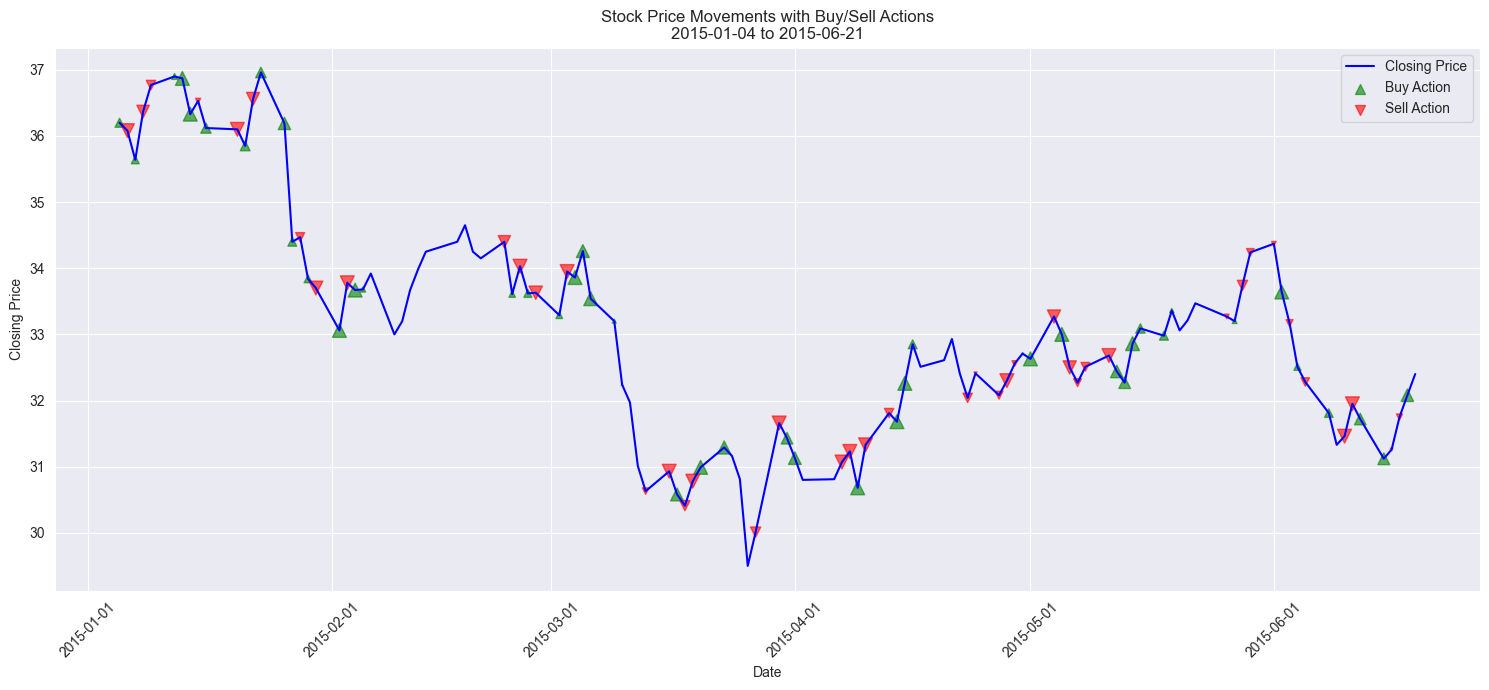

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import matplotlib.dates as mdates

# Paths to your CSV files
actions_file = 'results/actions_trade_robustness_0.csv'
price_file = 'datasets/processed_sanity.csv'

# Read the actions CSV
actions_df = pd.read_csv(actions_file)

# Read the price CSV
price_df = pd.read_csv(price_file)

# Define a function to parse the actions
def parse_action(action_str):
    try:
        # Convert the string representation of the list to an actual list
        action_list = ast.literal_eval(action_str)
        # Assuming one action per date; extract the first element
        return action_list[0]
    except (ValueError, SyntaxError):
        # In case of parsing errors, return 0 (no action)
        return 0

# Apply the parsing function to the 'actions' column
actions_df['action'] = actions_df['actions'].apply(parse_action)

# Keep only relevant columns
actions_df = actions_df[['date', 'action']]

# Convert 'date' columns to datetime objects
actions_df['date'] = pd.to_datetime(actions_df['date'])
price_df['date'] = pd.to_datetime(price_df['date'])

# Define the window parameters
start_date = '2015-01-04'
end_date = '2015-06-21'

# Filter the DataFrames based on the window
actions_window_df = actions_df[(actions_df['date'] >= start_date) & (actions_df['date'] <= end_date)]
price_window_df = price_df[(price_df['date'] >= start_date) & (price_df['date'] <= end_date)]

# Merge on 'date' using an inner join to keep only matching dates
merged_window_df = pd.merge(price_window_df, actions_window_df, on='date', how='inner')

# Sort by date to ensure chronological order
merged_window_df.sort_values('date', inplace=True)

# Create separate DataFrames for buy and sell actions
buy_actions = merged_window_df[merged_window_df['action'] > 0].copy()
sell_actions = merged_window_df[merged_window_df['action'] < 0].copy()

# Define scaling factors for marker sizes
buy_marker_size = 100  # Adjust as needed
sell_marker_size = 100  # Adjust as needed

# Calculate marker sizes based on action magnitude
if not buy_actions.empty:
    buy_actions['size'] = (buy_actions['action'] / buy_actions['action'].max()) * buy_marker_size
else:
    buy_actions['size'] = []

if not sell_actions.empty:
    sell_actions['size'] = (abs(sell_actions['action']) / abs(sell_actions['action']).max()) * sell_marker_size
else:
    sell_actions['size'] = []

# Set up the plot
plt.figure(figsize=(15, 7))

# Plot the stock's closing price
plt.plot(merged_window_df['date'], merged_window_df['close_0_s'], label='Closing Price', color='blue')

# Plot buy actions
if not buy_actions.empty:
    plt.scatter(buy_actions['date'], buy_actions['close_0_s'],
                label='Buy Action',
                marker='^',
                color='green',
                s=buy_actions['size'],
                alpha=0.6)

# Plot sell actions
if not sell_actions.empty:
    plt.scatter(sell_actions['date'], sell_actions['close_0_s'],
                label='Sell Action',
                marker='v',
                color='red',
                s=sell_actions['size'],
                alpha=0.6)

# Enhance the plot with titles and labels
plt.title(f'Stock Price Movements with Buy/Sell Actions\n{start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)

# Improve date formatting on the x-axis
date_format = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [52]:
processed

,date,open,high,low,close,volume,tic,day,close_-1_s,close_-2_s,close_-3_s,close_-4_s,close_-5_s,close_0_s,turbulence
0,2010-01-04,13.519428,20.879999,21.030001,20.790001,47800900,INTC,0,0.000000,0.000000,0.000000,0.000000,0.000000,20.790001,0.000000
1,2010-01-05,13.512956,20.870001,20.990000,20.940001,52357700,INTC,1,0.721499,0.721499,0.721499,0.721499,0.721499,20.940001,0.000000
2,2010-01-06,13.467624,20.799999,20.930000,20.809999,40037400,INTC,2,-0.620826,0.096193,0.096193,0.096193,0.096193,20.809999,0.000000
3,2010-01-07,13.338133,20.600000,20.760000,20.730000,54041500,INTC,3,-0.384430,-1.002870,-0.288607,-0.288607,-0.288607,20.730000,0.000000
4,2010-01-08,13.487050,20.830000,20.889999,20.540001,48234700,INTC,4,-0.916539,-1.297446,-1.910218,-1.202501,-1.202501,20.540001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3734,2024-11-04,22.520000,22.520000,23.000000,22.959999,84616300,INTC,0,-0.173917,3.656883,2.408559,0.393521,1.279219,22.959999,0.000180
3735,2024-11-05,23.320000,23.320000,23.580000,22.580000,59153300,INTC,1,-1.655049,-1.826087,1.941311,0.713648,-1.268041,22.580000,0.245863
3736,2024-11-06,25.049999,25.049999,25.120001,24.299999,116760500,INTC,2,7.617357,5.836238,5.652171,9.706545,8.385366,24.299999,6.517250
3737,2024-11-07,26.230000,26.230000,26.379999,25.430000,101489300,INTC,3,4.650210,12.621791,10.757845,10.565219,14.808130,25.430000,2.398577
